In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_histogram(data, num_bins, bottom=None):
    plt.hist(data, bins=num_bins, bottom=bottom, color='blue', alpha=0.7)
    plt.xlabel('z value')
    plt.ylabel('Frequency')
    plt.title('Sensor calibration errors, normalised by standard deviation')

# Load data from CSV file
def load_data_from_csv(file_path):
    data = pd.read_csv(file_path)
    return data

# where to save plots
overwrite = True
save_path = "/home/luke/Documents/thesis_plots/"

import sys
pathhere = "/home/luke/mujoco-devel/rl/"
sys.path.insert(0, pathhere)
from env.MjEnv import MjEnv
mjenv = MjEnv()
from TrainingManager import TrainingManager

/tmp/ipykernel_3010858/300713432.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(labels)


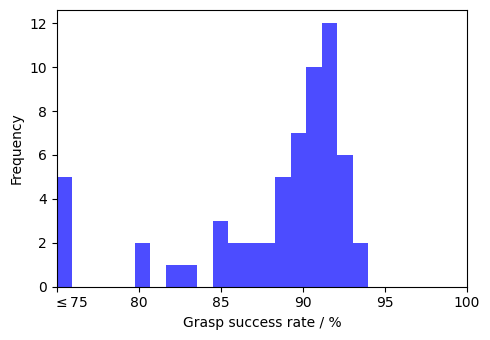

In [2]:
def plot_histogram(data, num_bins, bottom=None):
    plt.hist(data, bins=num_bins, bottom=bottom, color='blue', alpha=0.7)
    plt.xlabel('z value')
    plt.ylabel('Frequency')
    plt.title('Sensor calibration errors, normalised by standard deviation')

# Path to your CSV file (replace 'data.csv' with your file path)
csv_file_path = 'training_spread.csv'

# Load data from CSV file
data = load_data_from_csv(csv_file_path)

# Extract the column of interest (replace 'column_name' with the name of the column you want to plot)
column_name = ' set8_fullset_1500'
data_to_plot = np.array(data[column_name]) * 100
data_to_plot = np.clip(data_to_plot, 75, 100)
num_bins = 20

fig, axs = plt.subplots(1, 1)

_, bins, patches = axs.hist(data_to_plot, bins=num_bins, color="blue", alpha=0.7)
axs.set_xlabel("Grasp success rate / %")
axs.set_ylabel("Frequency")
axs.set_xlim([75, 100])

# xlabels = np.round(bins[0:].astype(float),2).astype(str)
# xlabels[0] += '+'
# N_labels = len(xlabels)

# plt.xticks(num_bins * np.arange(N_labels))
# axs.set_xticklabels(xlabels)
# axs.set_xlim([0.75, 1.0])

labels = axs.get_xticklabels()
labels[0] = r"      $\leq$75"
axs.set_xticklabels(labels)

fig.set_size_inches(5, 3.5)
fig.tight_layout()

if True and overwrite: fig.savefig(save_path + "training_spread.png")

In [3]:
import scipy.stats as stats
import math

confidence_level = 0.95
stdevs_from_mean = 1.0

probability_of_success = 1 - stats.norm.cdf(stdevs_from_mean)
n = math.ceil(math.log(1 - confidence_level) / math.log(1 - probability_of_success))

print(f"Number of runs needed to have {confidence_level*100:.0f}% confidence at least one is greater than {stdevs_from_mean} standard deviations above the mean:", n)

Number of runs needed to have 95% confidence at least one is greater than 1.0 standard deviations above the mean: 18


In [4]:
import math

n = 15  # number of runs
confidence_level = 0.95

probability_of_success = 1 - (1 - confidence_level) ** (1 / n)
stdevs_from_mean = -stats.norm.ppf(probability_of_success)

print("Probability of success:", probability_of_success)
print(f"Given {n} runs, there is {confidence_level*100:.0f}% confidence at least one is greater than {stdevs_from_mean:.2f} standard deviations above the mean")

Probability of success: 0.18103627252208465
Given 15 runs, there is 95% confidence at least one is greater than 0.91 standard deviations above the mean


In [5]:
def make_tm():
  tm = TrainingManager(log_level=0)
  tm.settings["savedir"] = "/home/luke/mujoco-devel/rl/models/"
  tm.trainer = tm.make_trainer(None, None)
  return tm

def get_jobs_from_timestamp(timestamp, run_name_prefix=None):
  """
  Find all the jobs with a particular timestamp
  """

  tm = make_tm()
  tm.set_group_run_name(job_num=1, timestamp=timestamp, prefix=run_name_prefix)
  match_str = tm.run_name[:-3]

  # get all the run folder corresponding to this timestamp
  group_path = tm.trainer.savedir + "/" + tm.group_name
  run_folders = [x for x in os.listdir(group_path) if x.startswith(match_str)]

  job_nums = []

  for folder in run_folders:
    num = folder.split(match_str)[-1][2:] # from _A5 -> 5"
    job_nums.append(int(num))

  # sort into numeric ascending order
  job_nums.sort()

  # check for failures
  if len(job_nums) == 0:
    print(f"launch_training.py warning: get_jobs_from_timestamp found zero trainings matching '{match_str}'")

  return job_nums

def load_results(timestamp, jobs=None):
  """
  Load track results for a series of trainings
  """

  tm = make_tm()
  trackdata = []

  if jobs is None:
    if not isinstance(timestamp, list):
      timestamp = [timestamp]
    for t in timestamp:
      jobs = get_jobs_from_timestamp(t)
      for j in jobs:
        # load tracking information for this training
        tm.load(job_num=j, timestamp=t, trackonly=True)
        trackdata.append(tm.trainer.track)
  else:
    for j in jobs:
      # load tracking information for this training
      tm.load(job_num=j, timestamp=timestamp, trackonly=True)
      trackdata.append(tm.trainer.track)

  return trackdata

def load_rewards_vector(timestamp, jobs=None, min_sr=-1, sort=False):
  """
  Load training results into a vector, with optional filters
  """

  data = load_results(timestamp=timestamp, jobs=jobs)

  # can sort by successful grasp
  if sort:
    data = sorted(data, key=lambda x: np.max(x.avg_successful_grasp))

  # for d in data:
  #   id = np.argmax(d.avg_successful_grasp)
  #   print(d.test_rewards[id])
  # print(f"Quartiles: {np.max(data[0].avg_successful_grasp)} / {np.max(data[15].avg_successful_grasp)} / {np.max(data[30].avg_successful_grasp)} / {np.max(data[45].avg_successful_grasp)}")

  # get vectors as numpy arrays, and only count trainings that finished
  data_length = 0
  for i, d in enumerate(data):
    # print(i, "length", len(d.train_avg_rewards))
    if np.max(d.avg_successful_grasp) < min_sr: continue
    if len(d.train_avg_rewards) > data_length:
      data_length = len(d.train_avg_rewards)
      episodes = d.train_avg_episodes
      rewards = [d.train_avg_rewards]
    elif len(d.train_avg_rewards) == data_length:
      rewards.append(d.train_avg_rewards)

  print(f"Number of runs used {len(rewards)} out of {len(data)}")

  return rewards, episodes

Number of runs used 60 out of 60


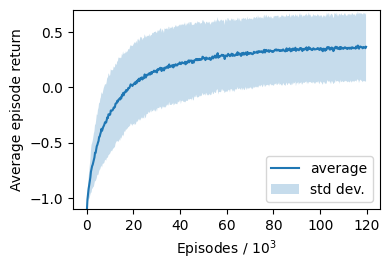

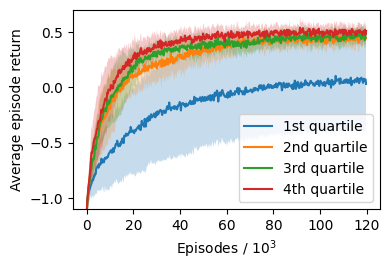

In [6]:
timestamp = ["26-04-24_17-01", "26-04-24_17-04"]
rewards, episodes = load_rewards_vector(timestamp=timestamp, sort=True, min_sr=0.0)

eps = episodes / 1e3

subplot = False
if subplot:
  fig, axs = plt.subplots(1, 2)
else:
  figs = []
  axs = []
  for i in range(2):
    f, a = plt.subplots(1, 1)
    figs.append(f)
    axs.append(a)

# first plot has overall average
avg = np.average(rewards, axis=0)
lstd = avg - np.std(rewards, axis=0)
ustd = avg + np.std(rewards, axis=0)
axs[0].plot(eps, avg, label="average")
axs[0].fill_between(eps, lstd, ustd, alpha=0.25, label="std dev.")

# second plot has quartiles
labels = ["1st quartile", "2nd quartile", "3rd quartile", "4th quartile"]
split = 15
for i in range(int(60/split)):
  avg = np.average(rewards[i*split:(i+1)*split+1], axis=0)
  lstd = avg - np.std(rewards[i*split:(i+1)*split+1], axis=0)
  ustd = avg + np.std(rewards[i*split:(i+1)*split+1], axis=0)
  axs[1].plot(eps, avg, label=labels[i])
  axs[1].fill_between(eps, lstd, ustd, alpha=0.25)

for i in range(len(axs)):
  axs[i].legend(loc="lower right")
  axs[i].set_ylabel("Average episode return")
  axs[i].set_xlabel(r"Episodes / $10^{3}$")
  axs[i].set_ybound(lower=-1.1, upper=0.7)
  if not subplot:
    figs[i].set_size_inches(5*0.8, 3.5*0.8)
    figs[i].tight_layout()
    if False and overwrite: figs[i].savefig(save_path + f"training_spread_return_{i+1}.png")

if subplot:
  fig.set_size_inches(5*(len(axs)), 3.5)
  fig.tight_layout()
  if False and overwrite: fig.savefig(save_path + f"training_spread_return_subplot.png")

Number of runs used 55 out of 55
Number of runs used 15 out of 15
Number of runs used 15 out of 15


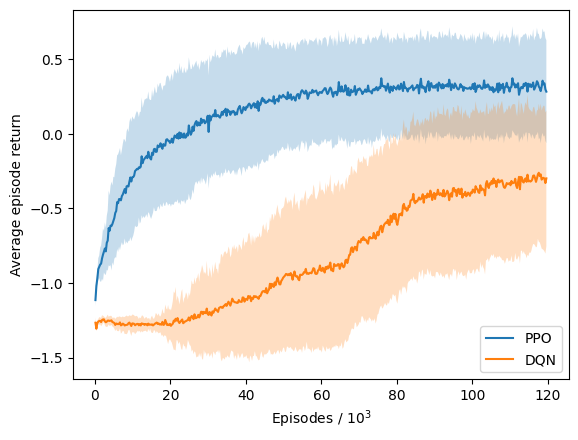

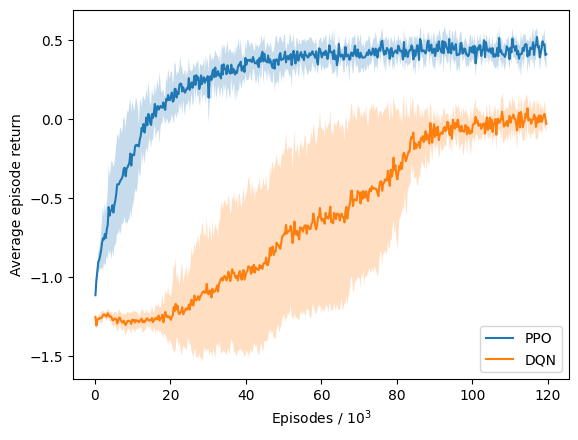

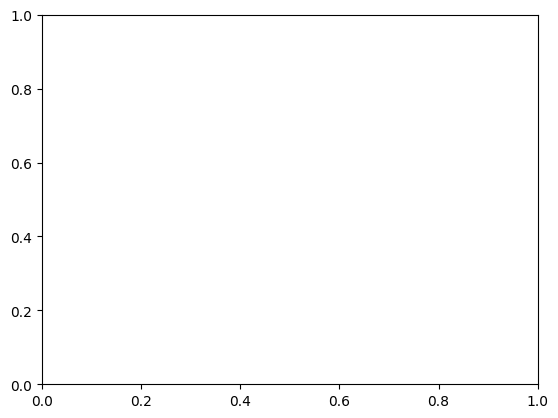

In [9]:
timestamp = ["26-04-24_17-01", "18-06-24_09-54"]
rewards, episodes = load_rewards_vector(timestamp=timestamp, sort=True, min_sr=0.0)

ppo_rewards, ppo_episodes = load_rewards_vector(timestamp=timestamp[0], jobs=list(range(1, 16)), sort=True)
dqn_rewards, dqn_episodes = load_rewards_vector(timestamp=timestamp[1], jobs=None, sort=True)

all_rewards = [ppo_rewards, dqn_rewards]
all_episodes = [ppo_episodes, dqn_episodes]
labels = ["PPO", "DQN"]

fig, axs = plt.subplots(1, 1)
fig2, axs2 = plt.subplots(1, 1)
fig3, axs3 = plt.subplots(1, 1) # add test performances?

for i in range(len(all_rewards)):

  rewards = all_rewards[i]
  eps = all_episodes[i] / 1e3

  # first plot has overall average
  avg = np.average(rewards, axis=0)
  lstd = avg - np.std(rewards, axis=0)
  ustd = avg + np.std(rewards, axis=0)
  axs.plot(eps, avg, label=labels[i])
  axs.fill_between(eps, lstd, ustd, alpha=0.25)

  # plot median upwards on other plot
  s1 = 8
  s2 = 16
  avg = np.average(rewards[s1:s2], axis=0)
  lstd = avg - np.std(rewards[s1:s2], axis=0)
  ustd = avg + np.std(rewards[s1:s2], axis=0)
  axs2.plot(eps, avg, label=labels[i])
  axs2.fill_between(eps, lstd, ustd, alpha=0.25)

axs = [axs, axs2]

for i in range(len(axs)):
  axs[i].legend(loc="lower right")
  axs[i].set_ylabel("Average episode return")
  axs[i].set_xlabel(r"Episodes / $10^{3}$")
  # axs[i].set_ybound(lower=-1.1, upper=0.7)
  # if not subplot:
  #   figs[i].set_size_inches(5*0.8, 3.5*0.8)
  #   figs[i].tight_layout()
  #   if False and overwrite: figs[i].savefig(save_path + f"training_spread_return_{i+1}.png")

# if subplot:
#   fig.set_size_inches(5*(len(axs)), 3.5)
#   fig.tight_layout()
#   if False and overwrite: fig.savefig(save_path + f"training_spread_return_subplot.png")

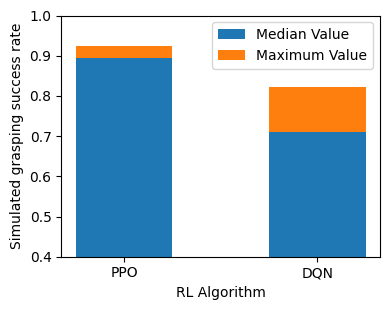

In [12]:
def plot_max_median(labels, medians, maxes, title=None):
  """
  Plot a stacked bar chart of median and max training performance
  """

  weight_counts = {
      "Median Value": np.array(medians),
      "Maximum Value": np.array(maxes) - np.array(medians),
  }
  width = 0.5

  fig, ax = plt.subplots()
  bottom = np.zeros(len(labels))

  for boolean, weight_count in weight_counts.items():
      p = ax.bar(labels, weight_count, width, label=boolean, bottom=bottom)
      bottom += weight_count

  if title is not None:
     ax.set_title("Number of penguins with above average body mass")
  ax.legend(loc="upper right")

  ax.set_ylabel("Simulated grasping success rate")
  ax.set_ylim(bottom=0.4, top=1.0)
  fig.set_size_inches(5*0.8, 4*0.8)
  fig.tight_layout()

  return fig, ax

labels = ["PPO", "DQN"]
medians = [
  0.895,
  0.709
]
maxes = [
  0.924,
  0.821
]

fig1, ax1 = plot_max_median(labels, medians, maxes)

ax1.set_xlabel("RL Algorithm")
fig1.tight_layout()

if False and overwrite: 
  fig1.savefig(save_path + "stiffness_pilot.png")